In [31]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import networkx as nx

In [32]:
d = load_dataset("NousResearch/hermes-function-calling-v1")

In [33]:
d['train']

Dataset({
    features: ['id', 'conversations', 'category', 'subcategory', 'task'],
    num_rows: 1893
})

In [66]:
d['train'][123].keys()

dict_keys(['id', 'conversations', 'category', 'subcategory', 'task'])

In [67]:
d['train'][123]

{'id': '936b90da-dbeb-4864-a6e6-28899965265d',
 'conversations': [{'from': 'system',
   'value': "You are an expert in composing functions. You are given a question and a set of possible functions.\nBased on the question, you will need to make one or more function/tool calls to achieve the purpose.\nIf none of the function can be used, point it out. If the given question lacks the parameters required by the function,\nalso point it out. You should only return the function call in tools call sections.\nIf you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]\nYou SHOULD NOT include any other text in the response.\nHere is a list of functions in JSON format that you can invoke.\n[{'type': 'function', 'function': {'name': 'scale_up_cluster', 'description': 'Scales up the number of compute nodes in an HPC cluster.', 'parameters': {'type': 'object', 'properties': {'cluster_nam

In [36]:
d['train'][400]

{'id': 'f9b15d86-fb69-4f05-a65e-18f2f7b5369d',
 'conversations': [{'from': 'system',
   'value': "You are a function calling AI model. You are provided with function signatures within <tools> </tools> XML tags. You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.\n<tools>\n[{'type': 'function', 'function': {'name': 'min_max_normalize', 'description': 'Apply Min-Max normalization to scale features in the dataset to a specified range.', 'parameters': {'type': 'object', 'properties': {'data': {'type': 'string', 'description': 'The path to the dataset file.'}, 'feature_range': {'type': 'object', 'properties': {'min': {'type': 'number', 'description': 'The minimum value of the target range for normalization.'}, 'max': {'type': 'number', 'description': 'The maximum value of the target range for normalization.'}}, 'required': ['min', 'max']}}, 'required': ['data', 'feature_range']}}}, {'type': 'function', 'function'

So we need to address a few things: 

Mapping:
System is fine but we need to change the function and also the XML tag nonsense

Human -> User

GPT -> Assistant

In [37]:
def process_dataset(dataset):
   def replace_terms(data):
       if isinstance(data, str):
           return data.replace('human', 'user').replace('gpt', 'assistant')
       elif isinstance(data, list):
           return [replace_terms(item) for item in data]
       elif isinstance(data, dict):
           return {k: replace_terms(v) for k, v in data.items()}
       return data
   
   return dataset.map(lambda x: {k: replace_terms(v) for k, v in x.items()})

processed_dataset = process_dataset(d)

Map:   0%|          | 0/1893 [00:00<?, ? examples/s]

In [38]:
d = processed_dataset

In [39]:
d['train'][123]

{'id': '936b90da-dbeb-4864-a6e6-28899965265d',
 'conversations': [{'from': 'system',
   'value': "You are a function calling AI model. You are provided with function signatures within <tools> </tools> XML tags. You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.\n<tools>\n[{'type': 'function', 'function': {'name': 'scale_up_cluster', 'description': 'Scales up the number of compute nodes in an HPC cluster.', 'parameters': {'type': 'object', 'properties': {'cluster_name': {'type': 'string', 'description': 'The name of the HPC cluster to scale up.'}, 'node_type': {'type': 'string', 'description': 'The type of compute node to add to the cluster.'}, 'additional_nodes': {'type': 'integer', 'description': 'The number of additional compute nodes to add to the cluster.'}}, 'required': ['cluster_name', 'node_type', 'additional_nodes']}}}, {'type': 'function', 'function': {'name': 'scale_down_cluster', 'description': '

In [40]:
NEW_SYSTEM_MESSAGE = """You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.
If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.
Here is a list of functions in JSON format that you can invoke."""

In [41]:
def format_function_call(tool_call_str):
    # Extract function name and arguments from the old format
    try:
        import ast
        tool_call = ast.literal_eval(tool_call_str.replace('<tool_call>\n', '').replace('</tool_call>\n', ''))
        name = tool_call['name']
        args = tool_call['arguments']
        # Convert to new format
        args_str = ', '.join(f"{k}='{v}'" if isinstance(v, str) else f"{k}={v}" for k, v in args.items())
        return f"{name}({args_str})"
    except:
        return tool_call_str

def clean_assistant_response(response):
   # Remove XML tags and formatting
   response = response.replace('<tool_call>', '').replace('</tool_call>', '')
   response = response.strip('[]').strip()
   
   # Format each function call
   calls = []
   for call in response.split(','):
       if 'arguments' in call:
           # Parse old JSON format
           import ast
           try:
               tool_call = ast.literal_eval(call.strip())
               name = tool_call['name']
               args = tool_call['arguments']
               args_str = ', '.join(f"{k}='{v}'" if isinstance(v, str) else f"{k}={v}" 
                                 for k, v in args.items())
               calls.append(f"{name}({args_str})")
           except:
               continue
       else:
           calls.append(call.strip())
   return f"[{', '.join(calls)}]"

def process_conversation(example, mode='system'):
   conversations = example['conversations']
   
   if mode == 'system':
       new_conversations = []
       for conv in conversations:
           if conv['from'] == 'system':
               if '<tools>' in conv['value']:
                   tools_json = conv['value'].split('<tools>\n')[1].split('</tools>\n')[0]
               else:
                   tools_json = conv['value'].split('Here is a list of functions in JSON format that you can invoke.\n')[1]
               conv['value'] = f"{NEW_SYSTEM_MESSAGE}\n{tools_json}"
           elif conv['from'] == 'assistant':
               conv['value'] = clean_assistant_response(conv['value'])
           new_conversations.append(conv)
   else:
       new_conversations = []
       tools_json = None
       for conv in conversations:
           if conv['from'] == 'system':
               if '<tools>' in conv['value']:
                   tools_json = conv['value'].split('<tools>\n')[1].split('</tools>\n')[0]
               else:
                   tools_json = conv['value'].split('Here is a list of functions in JSON format that you can invoke.\n')[1]
               continue
           elif conv['from'] == 'user':
               conv['value'] = f"{conv['value']}\n\n{NEW_SYSTEM_MESSAGE}\n{tools_json}"
           elif conv['from'] == 'assistant':
               conv['value'] = clean_assistant_response(conv['value'])
           new_conversations.append(conv)
   
   example['conversations'] = new_conversations
   return example

def process_dataset(inp_dataset, mode='system'):
   dataset = inp_dataset
   processed = dataset.map(lambda x: process_conversation(x, mode=mode))
   return processed

In [42]:
d = process_dataset(d)

Map:   0%|          | 0/1893 [00:00<?, ? examples/s]

In [43]:
d['train'][123]

{'id': '936b90da-dbeb-4864-a6e6-28899965265d',
 'conversations': [{'from': 'system',
   'value': "You are an expert in composing functions. You are given a question and a set of possible functions.\nBased on the question, you will need to make one or more function/tool calls to achieve the purpose.\nIf none of the function can be used, point it out. If the given question lacks the parameters required by the function,\nalso point it out. You should only return the function call in tools call sections.\nIf you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]\nYou SHOULD NOT include any other text in the response.\nHere is a list of functions in JSON format that you can invoke.\n[{'type': 'function', 'function': {'name': 'scale_up_cluster', 'description': 'Scales up the number of compute nodes in an HPC cluster.', 'parameters': {'type': 'object', 'properties': {'cluster_nam

In [44]:
set(d['train']['category'])

{'AI Model Integration',
 'API Call',
 'Accounting & Finance',
 'Algorithmic Trading',
 'Annotation',
 'Blockchain Integration',
 'Business Intelligence',
 'CRM',
 'Cloud Platforms',
 'Code Interpreters',
 'Communication Services Software',
 'Compliance',
 'Consumer Discretionary Software',
 'Consumer Staples Software',
 'Data Centers and High Performance Computing',
 'Data Privacy',
 'Data Processing',
 'Database Management',
 'Decentralized Apps (DApps)',
 'Desktop Applications',
 'DevOps',
 'Document Ranking',
 'E-commerce Platforms',
 'Energy Software',
 'Financial Services Apps',
 'Financial Software',
 'Git Operations',
 'HR',
 'Healthcare Software',
 'Identity and Access Management (IAM)',
 'Industrial Software',
 'Information Extraction',
 'Information Retrieval (RAG)',
 'Information Technology Software',
 'IoT Platforms',
 'IoT and Home Automation',
 'Low-Code Enterprise Platforms',
 'Marketing',
 'Materials Software',
 'Mobile Applications',
 'Model APIs',
 'Named Entity Reco

In [45]:
def analyze_conversation(example):
   try:
       conv_data = {
           'id': example['id'],
           'category': example['category'],
           'subcategory': example['subcategory'],
           'task': example['task'],
           'split': example.get('split', 'unspecified'),
           'conversation_turns': len(example['conversations']),
           'user_msg': '',
           'assistant_msg': ''
       }
       
       # Get messages and functions
       available_funcs = []
       for conv in example['conversations']:
           if conv['from'] == 'system':
               try:
                   functions_str = conv['value'][conv['value'].find('['):conv['value'].rfind(']')+1]
                   available_funcs = json.loads(functions_str)
               except:
                   pass
           elif conv['from'] == 'user':
               conv_data['user_msg'] = conv['value']
           elif conv['from'] == 'assistant':
               conv_data['assistant_msg'] = conv['value']

       # Process called functions
       called_funcs = [f.strip() for f in conv_data['assistant_msg'].strip('[]').split(',') if '(' in f]
       
       conv_data.update({
           'num_available_functions': len(available_funcs),
           'num_tool_calls': len(called_funcs),
           'human_msg_length': len(conv_data['user_msg'].split()),
           'available_functions': [f['function']['name'] for f in available_funcs] if available_funcs else [],
           'called_functions': called_funcs
       })
       
       return conv_data
   except Exception as e:
       print(f"Error processing example {example.get('id', 'unknown')}: {str(e)}")
       return None

def create_analysis_df(dataset):
   #dataset = load_dataset(dataset_name)
   analyses = [a for a in [analyze_conversation(ex) for ex in dataset['train']] if a is not None]
   return pd.DataFrame(analyses)

In [46]:
df = create_analysis_df(d)

Dataset Overview:
Total samples: 1893
Number of unique categories: 63
Number of unique subcategories: 865

Average tool calls per conversation: 0.04
Average available functions: 0.00


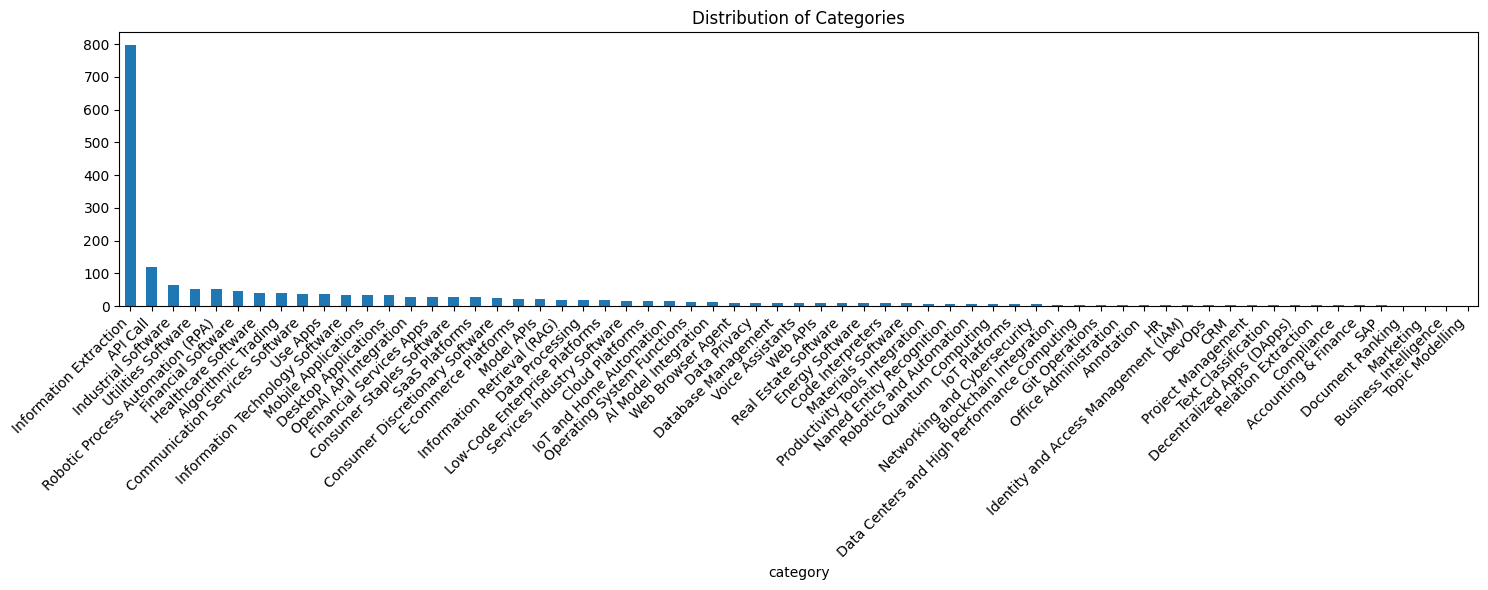

In [48]:
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Number of unique categories: {df['category'].nunique()}")
print(f"Number of unique subcategories: {df['subcategory'].nunique()}")
print(f"\nAverage tool calls per conversation: {df['num_tool_calls'].mean():.2f}")
print(f"Average available functions: {df['num_available_functions'].mean():.2f}")

# Category Analysis
plt.figure(figsize=(15, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [49]:
subcategory_counts = df['subcategory'].value_counts().head(10)
print("\nTop 10 Subcategories:")
print(subcategory_counts)


Top 10 Subcategories:
subcategory
Json Schema          793
 JSON Schema          26
Android               21
JSON Schema           14
iPhone                13
Data Retrieval        11
Microsoft 365          7
Hugging Face           7
Data Modification      7
Salesforce             5
Name: count, dtype: int64


/tmp/ipykernel_4105860/3377049099.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


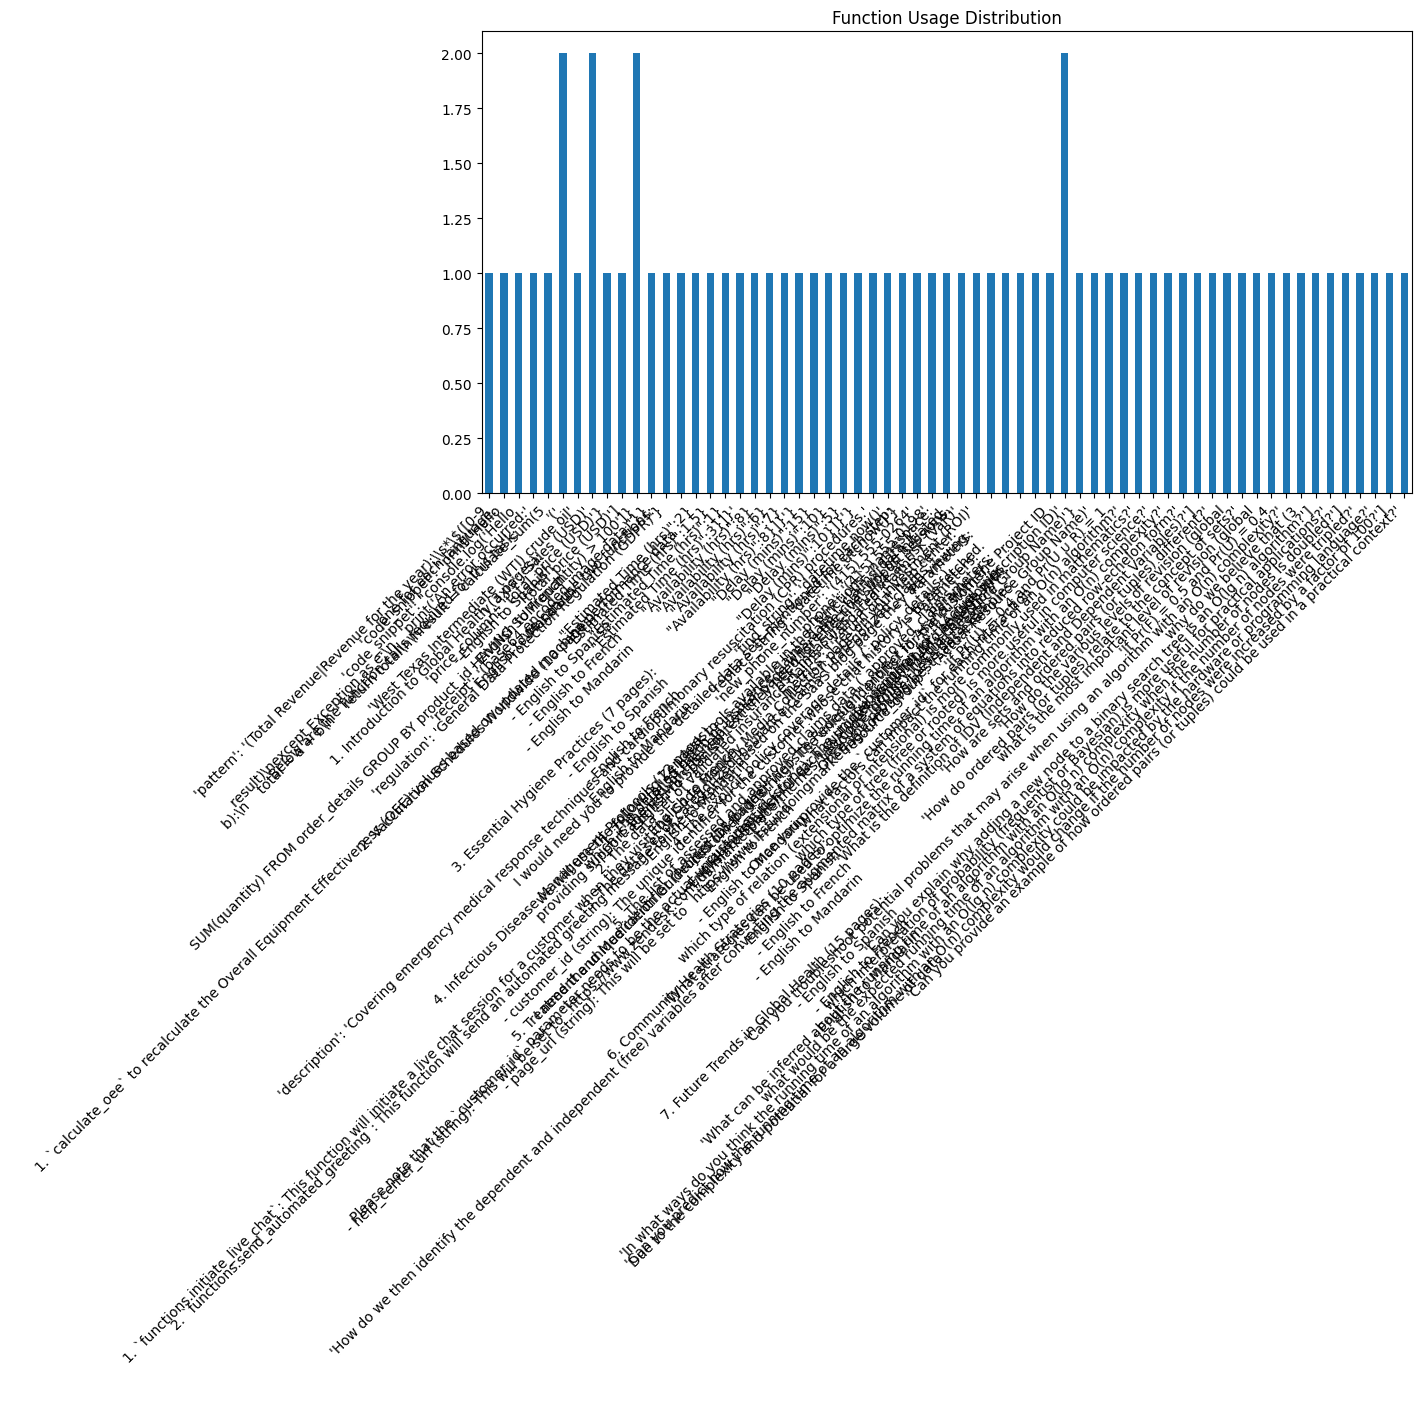

In [50]:
all_called_functions = [f for funcs in df['called_functions'] for f in funcs]
function_counts = Counter(all_called_functions)

plt.figure(figsize=(12, 6))
pd.Series(function_counts).plot(kind='bar')
plt.title('Function Usage Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

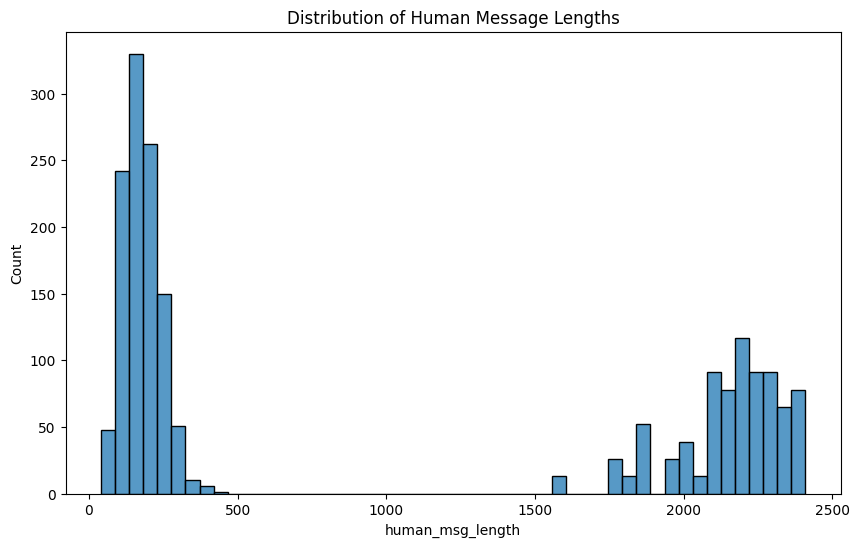

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='human_msg_length', bins=50)
plt.title('Distribution of Human Message Lengths')
plt.show()

In [52]:
function_pairs = []
for functions in df['called_functions']:
    if len(functions) > 1:
        pairs = [(f1, f2) for i, f1 in enumerate(functions) 
                for f2 in functions[i+1:]]
        function_pairs.extend(pairs)

In [53]:
cooccurrence = Counter(function_pairs)
print("\nTop Function Co-occurrences:")
for (f1, f2), count in sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{f1} & {f2}: {count}")


Top Function Co-occurrences:
'subscription_id': '(Actual Subscription ID)' & 'resource_group': '(Actual Resource Group Name)': 2
'code_snippet': "print('Hello & 'code_snippet': "console.log('Hello: 1
'(' & '(': 1
'y_axis': 'Sales (USD)' & 'y_axis': 'Sales (USD)': 1
'price_column': 'total_price (USD)'} & 'total_price (USD)']: 1


In [54]:
function_by_category = df.groupby('category')['called_functions'].apply(
    lambda x: Counter([f for funcs in x for f in funcs])
).reset_index()

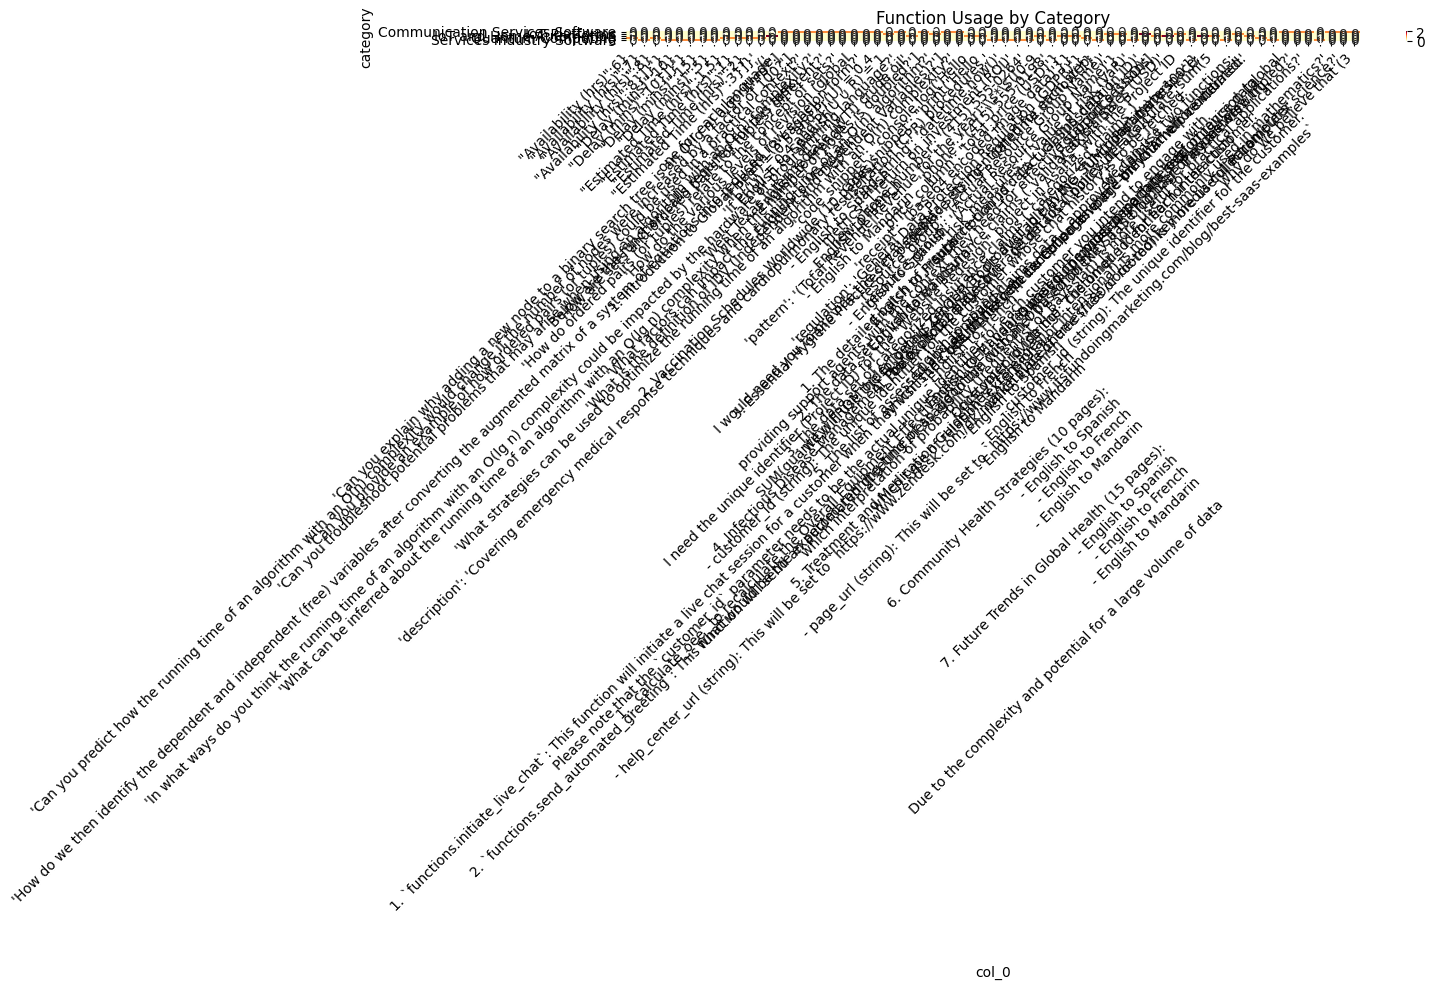

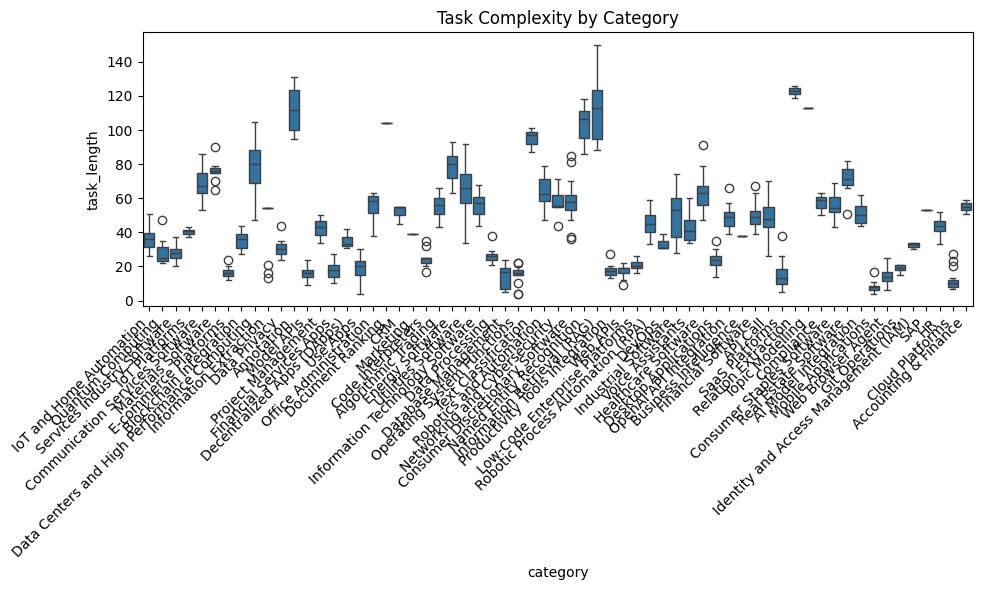

In [55]:
function_matrix = pd.crosstab(df['category'], 
                            pd.Series([f for funcs in df['called_functions'] for f in funcs]))

plt.figure(figsize=(15, 10))
sns.heatmap(function_matrix, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Function Usage by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Task Complexity Analysis
df['task_length'] = df['task'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='task_length', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Task Complexity by Category')
plt.tight_layout()
plt.show()

In [56]:
print("\nSample Conversation Analysis:")
sample_idx = np.random.randint(len(df))
sample = df.iloc[sample_idx]
print(f"\nCategory: {sample['category']}")
print(f"Task: {sample['task']}")
print(f"Available Functions: {sample['available_functions']}")
print(f"Called Functions: {sample['called_functions']}")


Sample Conversation Analysis:

Category: Model APIs
Task: Regression
Available Functions: []
Called Functions: []


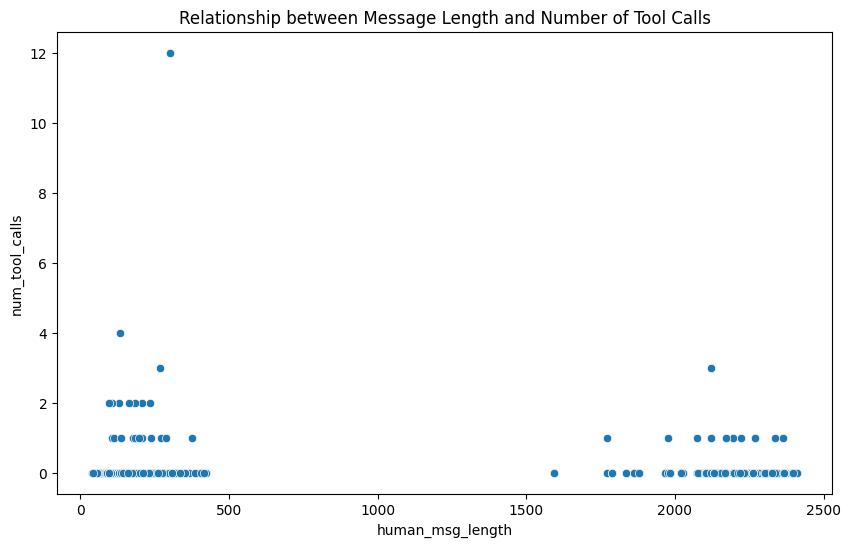

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='human_msg_length', y='num_tool_calls')
plt.title('Relationship between Message Length and Number of Tool Calls')
plt.show()

In [58]:
numerical_cols = ['num_tool_calls', 'num_available_functions', 
                 'human_msg_length', 'conversation_turns', 'task_length']
correlation_matrix = df[numerical_cols].corr()

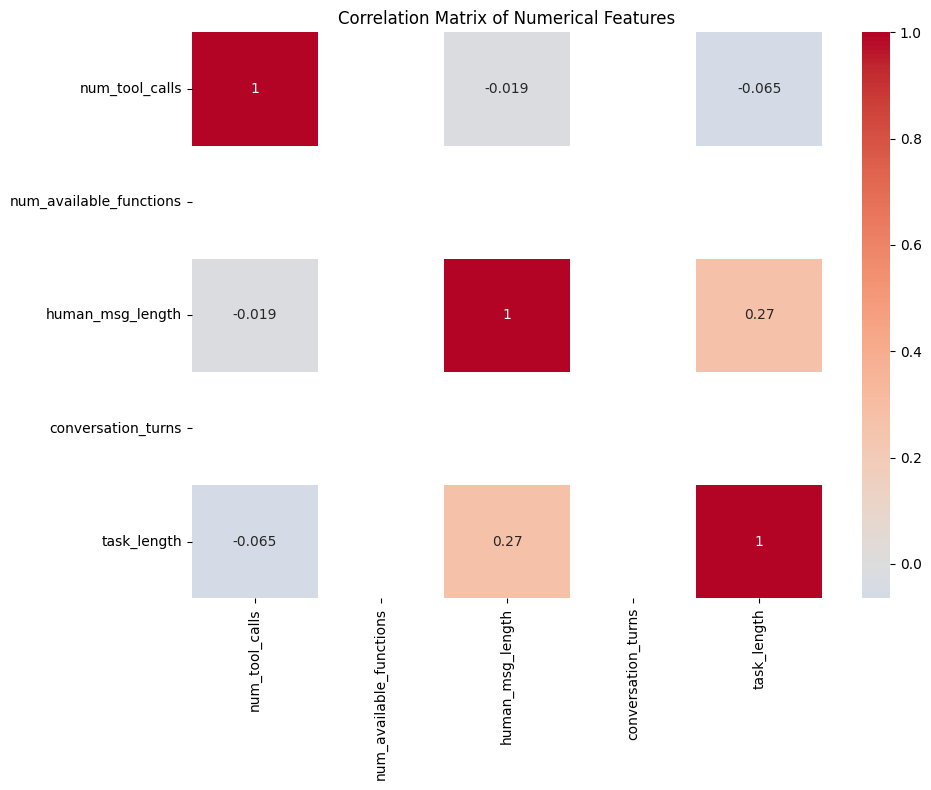

In [59]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [60]:
summary_stats = df.groupby('category').agg({
    'num_tool_calls': ['mean', 'std'],
    'human_msg_length': ['mean', 'std'],
    'conversation_turns': ['mean', 'std']
}).round(2)

print("\nSummary Statistics by Category:")
print(summary_stats)


Summary Statistics by Category:
                     num_tool_calls       human_msg_length         \
                               mean   std             mean    std   
category                                                            
AI Model Integration           0.00  0.00           171.17  34.04   
API Call                       0.00  0.00           139.69  47.69   
Accounting & Finance           0.00  0.00           150.50  12.02   
Algorithmic Trading            0.00  0.00           209.33  54.53   
Annotation                     0.00  0.00           169.75  91.85   
...                             ...   ...              ...    ...   
Use Apps                       0.00  0.00           126.27  33.26   
Utilities Software             0.02  0.14           225.37  49.40   
Voice Assistants               0.00  0.00           150.10  37.91   
Web APIs                       0.00  0.00           158.11  33.47   
Web Browser Agent              0.00  0.00           145.18  35.16   

